In [2]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests 
import time

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [137]:
# all rock releases in the UK
df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')
df_masters_scrapped.shape

(56660, 13)

In [144]:
df_masters_scrapped[df_masters_scrapped['master_id']==375118]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
50199,192160.0,375118.0,3845130,US,Chubby Checker,For Twisters Only,1960,28.93,12,"['LP', 'Album', 'Mono']",['Rock'],"['Rock & Roll', 'Rhythm & Blues', 'Twist']","American rock’n’roll vocalist, best known for ..."


# **1. Merge ``df_masters`` & ``df_ratings``**

In [126]:
# import the dataframes
df_masters = pd.read_csv('Datasets/df_masters_id0_1998.csv')                         # all rock releases in the UK
df_uk_rock_ratings = pd.read_csv('Datasets/df_uk_rock_ratings.csv')                 # df with the albums already cleaned
df_ratings_top = pd.read_csv('Datasets/df_ratings_top.csv', keep_default_na=False)  # all ratings, mostly from rock, worldwide

# print information
print(f'{df_masters.shape}: df_masters_id0_1998')
print(f'{df_uk_rock_ratings.shape}: df_uk_rock_ratings')
print(f'{df_ratings_top.shape}: df_ratings_top')

(1685, 13): df_masters_id0_1998
(12060, 13): df_uk_rock_ratings
(79626, 5): df_ratings_top


In [63]:
df_ratings_top.head(1)

,album_id,artist,title,rating,votes
0,37,Less Than Jake,Losing Streak,3.9,414


In [64]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15033166.0,0,31643455,UK,Isabel Shrine,What A Difference A Week Makes,1998,0.0,6,"['Album', 'Mini-Album']",['Rock'],"['Goth Rock', 'Darkwave']",NaN


In [65]:
df_masters['master_id'].isna().sum()

0

In [66]:
df_masters['master_id'].fillna(0, inplace=True)
df_masters['master_id'].isna().sum()

0

## **Concat with the albums previously cleaned**

In [67]:
df_uk_rock_ratings.shape

(12056, 13)

In [68]:
df_masters.shape

(1685, 13)

In [69]:
df_concat = pd.concat([df_uk_rock_ratings, df_masters])
df_concat.shape

(13741, 13)

In [70]:
df_masters = df_concat

## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [16]:
# all the artists in df_masters
df_masters['artist'].nunique()

7989

In [17]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

588

In [34]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(15584, 13): df_masters
(656, 13): df_masters_parenthesis


In [35]:
df_ratings_top['artist'].nunique()

23855

In [36]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_top_parenthesis = df_ratings_top[df_ratings_top['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_top_parenthesis['artist'].nunique()

701

In [37]:
# print information
print(f'{df_ratings_top.shape}: df_ratings_top')
print(f'{df_ratings_top_parenthesis.shape}: df_ratings_top_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [38]:
df_ratings_top_parenthesis.sample(5)

,album_id,artist,title,rating,votes
66859,299052,Vacations (AUS),Vibes and Days,3.87,15
66521,293448,Carnation (BE),Chapel of Abhorrence,3.35,40
34007,67551,Soundtrack (Video Game),The Legend of Zelda: Twilight Princess OST,4.23,80
39072,84542,Doom (JPN),Complicated Mind,4.16,25
36362,74638,Tempest (Can),Passages,3.73,37


In most of the artists, the information between parenthesis is the country of origin

In [39]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

2364       100% Proof
3971       100% Proof
2622     20/20 Vision
1164       38 Special
2445       38 Special
            ...      
3727              XIT
3045            Ya Ya
1735    Youth In Asia
3931              ZED
599              Zeno
Name: artist, Length: 656, dtype: object

In [40]:
# delete these characters
df_ratings_top_parenthesis_clean = df_ratings_top_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_top_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [41]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_top_parenthesis_clean, on='artist')

,artist
0,Alaska
1,Alaska
2,Alaska
3,Alaska
4,Attila
...,...
123,X
124,X
125,X
126,X


In [45]:
df_masters[df_masters['artist'].str.contains('Alaska ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1516,594810.0,309057.0,2702245,US,Alaska (8),The Pack,1985,42.32,9,"['LP', 'Album', 'Stereo']",['Rock'],['Hard Rock'],Alaska was a British hard rock band led by Ber...
2990,594810.0,591189.0,1175493,UK,Alaska (8),Heart Of The Storm,1984,0.00,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'AOR']",Alaska was a British hard rock band led by Ber...


In [44]:
df_ratings_top[df_ratings_top['artist'].str.contains('Alaska ')]

,album_id,artist,title,rating,votes
48864,135438,Alaska (USA),Everything is Fine,3.38,12
57915,203926,Alaska (USA),Shrine,3.54,12


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [71]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_masters['artist'].nunique()} unique artists in df_masters")

6482 unique artists in df_masters


In [72]:
df_ratings_top['artist'] = df_ratings_top['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_ratings_top['artist'].nunique()} unique artists in df_ratings_top")

23683 unique artists in df_ratings_top


## Sort columns

In [48]:
df_masters.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [49]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712.0,158153.0,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [50]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

In [51]:
df_uk_rock_ratings = df_uk_rock_ratings.reindex(columns=list_of_columns)
df_uk_rock_ratings.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712,158153,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [ ]:
# df_masters.to_csv('Datasets/df_masters.csv', index=False)

## &/and Cleaning

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [73]:
df_ratings_top[df_ratings_top['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
48952,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
51040,150508,Ultimate Spinach,Behold and See,3.89,23


In [74]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [75]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings_top[['artist', 'title']] = df_ratings_top[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [16]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


## Actual merge

In [76]:
df = pd.merge(
    df_ratings_top.assign(artist_lower=df_ratings_top['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_top['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(12063, 16)

In [77]:
row_diff = df.shape[0] - df_uk_rock_ratings.shape[0]
new_albums_percentage = round(row_diff / df_masters.shape[0]*100,2)

print(f"{row_diff} new albums added")
print(f"This is {new_albums_percentage} % of the albums I just got")

7 new albums added
This is 0.05 % of the albums I just got


In [78]:
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,40,Sparta,Wiretap Scars,3.79,431,253712.0,158153,426893,US,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [79]:
print(f"{round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have ratings")

87.79 % of the albums have ratings


### First inspection

**Change the dtype of ``artist_id``**

In [80]:
df[df['artist_id'].isna()]

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
7046,72484,George Michael,Older,4.0,77,NaN,0,6272825,UK,1996,58.72,11,"['Album', 'Promo']","['Electronic', 'Jazz', 'Rock']","['Downtempo', 'Synth-pop', 'Contemporary Jazz']",NaN


In [37]:
df[df['artist']=='George Michael'].sample(2)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
7052,72484,George Michael,Older,4.00,77,NaN,0,6272825,UK,1996,58.72,11,"['Album', 'Promo']","['Electronic', 'Jazz', 'Rock']","['Downtempo', 'Synth-pop', 'Contemporary Jazz']",NaN
956,4070,George Michael,Faith,3.66,142,32990.0,96689,413315,Europe,1987,47.52,9,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock', 'Funk / Soul', 'Pop']","['Soft Rock', 'Pop Rock']","George Michael (born 25 June 1963, East Finchl..."


In [81]:
df.loc[7046, 'artist_id'] = 32990

In [82]:
df['artist_id'] = df['artist_id'].astype(int)

In [83]:
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,40,Sparta,Wiretap Scars,3.79,431,253712,158153,426893,US,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [84]:
df = columns_show_ratings(df)

In [85]:
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,40,Sparta,Wiretap Scars,2002,3.79,431,47.62,12,US,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte...",253712,158153,426893


**I keep only rock albums**

In [86]:
# how many of them are Rock albums?
df = df[df['genres'].str.contains('Rock')]
df.shape

(12063, 16)

**Drop compilations**

In [87]:
df['release_type'].isna().sum()

0

In [88]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [89]:
# it's an american band, so I can just drop it
# df.drop(, inplace=True)
df['release_type'].isna().sum()

0

In [90]:
df = df[~df['release_type'].str.contains('Compilation')]
df.shape

(12063, 16)

In [91]:
# number of unique artists
df['artist'].nunique()

5094

## ``df`` real cleaning

I want to **drop duplicates** and releases from **bands outside of the UK**, I only want to keep brittish artists. Also **drop compilations and live albums**.

**Deleting artists from outside the UK**

In [92]:
delete_non_uk_artists(df)

Initial artists: 5094
Final artists: 5094


### Drop duplicates

In [94]:
df[['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks']].duplicated().sum()

1

In [95]:
# these albums are the same, except one entry has master_id=0
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks'], inplace=True)

In [96]:
# the real duplicated albums
df[['artist', 'title']].duplicated().sum()

2

In [106]:
# check one by one
df[df[['artist', 'title']].duplicated()].tail()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


**Check these duplicated albums in the original dataframes**

In [105]:
# to see the difference between the duplicated albums searching for the album name
df[df['title']=="Master Of Reality"].sort_values('year')

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
169,620,Black Sabbath,Master Of Reality,1971,4.45,3756,34.48,8,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Heavy Metal', 'Doom Metal']",Considered by many to be the first heavy metal...,144998,4844,590773


**Drop incorrect albums**

In [102]:
# check one by one if necessary
try:
    df.drop([170], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(12060, 16)


**Change specific values that are wrong/missing**

In [104]:
# change specific values that are wrong/missing

# df.loc[1615, 'title'] = 'Heroes'
# df.loc[8365, 'rating'] = 3.62
# df.loc[8365, 'votes'] = 13
df.loc[169, 'album_length'] = 34.48
# df.loc[8002, 'tracks'] = 14

In [103]:
# calculate the decimals of the album length (seconds)
29/60

0.48333333333333334

**``df_ratings_top``**

If there are two albums with the same name, but one is for instance an EP or a compilation I don't want to keep, I have to drop it from df,

but also from df_ratings_top, otherwise I will keep running into this duplicated album every time I add more albums

In [183]:
df_ratings_top[df_ratings_top['artist']=='New York Dolls']

,album_id,artist,title,rating,votes
3641,5562,New York Dolls,New York Dolls,3.97,386
5724,8501,New York Dolls,Too Much Too Soon,3.77,127
7344,10865,New York Dolls,One Day It Will Please Us To Remember...,3.06,52
33315,65305,New York Dolls,Rock'n Roll,4.00,11
36151,74079,New York Dolls,Cause I Sez So,2.71,29
36152,74083,New York Dolls,Dancing Backward In High Heels,2.35,24


In [116]:
df_ratings_top[df_ratings_top['title']=='Animal Tracks']

,album_id,artist,title,rating,votes
19214,30855,The Animals,Animal Tracks,3.68,11
19215,30856,The Animals,Animal Tracks,3.60,10


In [117]:
# check one by one if necessary
try:
    df_ratings_top.drop([4853], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_top.shape)
except:
    print("Couldn't drop these rows")
    print(df_ratings_top.shape)

Rows dropped
(79626, 5)


In [250]:
df_ratings_top.to_csv('Datasets/df_ratings_top.csv', index=False)

### **Drop live albums**

Let's try to detect the live albums by the title

**'Live at'**

In [107]:
df.shape

(12060, 16)

In [108]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 0 albums with 'Live at ' in the title


In [109]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [110]:
# correct, they are all live albums
df = df[~df['title'].str.contains('Live at ', case=False)]
df.shape

(12060, 16)

**'Live in'**

In [111]:
print(f"There are {df[df['title'].str.contains(r'^Live in ', case=False)].shape[0]} albums with 'Live in ' in the title")

There are 0 albums with 'Live in ' in the title


In [112]:
# Let's check them before deleting them
df[df['title'].str.contains(r'^Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [113]:
# I can drop them all
df = df[~df['title'].str.contains(r'^Live in ', case=False)]
df.shape

(12060, 16)

In [114]:
# This is a studio album
df[df['title'].str.contains('Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
10466,274989,IAMX,Alive In New Light,2018,3.42,12,40.13,9,UK & Europe,['Album'],"['Electronic', 'Rock']","['Alternative Rock', 'Electro']",IAMX is the solo musical project of [a209168] ...,192242,1318851,11504248


### **Dropping compilations sorting albums by the top rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [326]:
start_row = 0

df.sort_values(['votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
407,1484,Radiohead,OK Computer,1997,4.54,9186,0.00,16,Worldwide,"['LP', 'Album']","['Electronic', 'Rock']",['Alternative Rock'],Electronic and alternative rock (modern rock) ...,3840,21491,4950798
22,130,Pink Floyd,The Dark Side Of The Moon,1973,4.55,8048,0.00,10,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Prog Rock', 'Psychedelic Rock']",Pink Floyd was an English rock band from Londo...,45467,10362,1873013
51,226,Radiohead,Kid A,2000,4.43,7685,46.72,15,UK,"['10""', '33 ⅓ RPM', 'Album', 'Stereo']","['Electronic', 'Rock']","['Alternative Rock', 'IDM', 'Experimental']",Electronic and alternative rock (modern rock) ...,3840,21501,74743
142,531,Pink Floyd,Wish You Were Here,1975,4.63,7065,0.00,5,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Pink Floyd was an English rock band from Londo...,45467,11703,16211812
3670,21735,Radiohead,In Rainbows,2007,4.30,6734,42.63,10,Europe,"['LP', 'Album']","['Electronic', 'Rock']","['Alternative Rock', 'Art Rock', 'Experimental...",Electronic and alternative rock (modern rock) ...,3840,21520,1174296
19,110,Radiohead,The Bends,1995,4.10,6445,48.60,12,UK,"['LP', 'Album']",['Rock'],['Alternative Rock'],Electronic and alternative rock (modern rock) ...,3840,17008,5629921
431,1634,Pink Floyd,The Wall,1979,4.26,5917,80.62,26,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Prog Rock', 'Art Rock']",Pink Floyd was an English rock band from Londo...,45467,11329,27371856
38,185,Pink Floyd,Animals,1977,4.51,5420,41.52,5,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Pink Floyd was an English rock band from Londo...,45467,10370,391322
9,67,Black Sabbath,Paranoid,1970,4.52,5144,0.00,8,UK,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Heavy Metal']",Considered by many to be the first heavy metal...,144998,302,696772
17,96,Radiohead,Amnesiac,2001,3.91,5058,0.00,11,Europe,"['LP', '10""', 'Album']","['Electronic', 'Rock']","['Alternative Rock', 'Experimental']",Electronic and alternative rock (modern rock) ...,3840,2507,173980


In [325]:
# check one by one if necessary
try:
    df.drop([9140], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11739, 16)


### **Sort columns**

In [115]:
df = columns_hide_ratings(df)

In [117]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712.0,158153,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [118]:
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712,158153,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [119]:
df['artist_id'] = df['artist_id'].astype(int)

### **``year = 0``**

In [ ]:
# df = pd.read_csv('Datasets/df_uk_rock_ratings.csv')
# df.shape

(11752, 13)

In [120]:
df[df['year']==0].shape

(0, 13)

In [121]:
df[df['year']==0].head()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [ ]:
# df.loc[6659, 'year'] = 1971

In [266]:
non_uk_artists = ['Evanescence', "Stake", "Embrace", 'Ultimate Spinach', 'Jeff Buckley', 'Four Year Strong', 'Todd Rundgren', 'Lunatic Soul', 'Throwing Muses', 'The Cramps', 'American Football',
                'MD.45', 'Quiet Riot', 'Nine Inch Nails', 'Red House Painters', 'The Bronx', 'Weezer', 'Panchiko', 'Megadeth', 'The Band', 'Enslaved', 'Thin Lizzy', 'The Lucksmiths', 'Opeth',
                'Talking Heads', 'Rory Gallagher', 'Pearl Jam', 'My Bloody Valentine', 'The Doors', 'The Beach Boys', 'Metallica', 'Death', 'Bob Dylan', 'Tom Waits', 'Tool', 'Brand New',
                'Alice in Chains', 'Rush', 'Willie Nelson', 'Phil Lynott', 'Dead Can Dance', 'Bon Jovi', 'Paul Simon', 'At the Drive-In', 'Deftones', 'System of a Down', 'Green Day', 'Linkin Park',
                'Slayer', 'Neutral Milk Hotel', 'The Mars Volta', 'Rage Against the Machine', 'Mastodon', 'Queens of the Stone Age', 'Beach House', 'Turnover', 'A Day To Remember', 'Sahg', 'Rival Sons',
                'Minus the Bear', 'The Incredible Bongo Band', 'Jimi Hendrix', 'Framing Hanley', 'Bon Iver', 'Alter Bridge', 'Death From Above 1979', 'The Smashing Pumpkins', 'Arcade Fire',
                'Red Hot Chili Peppers', 'Nirvana', 'Between the Buried and Me', 'Something Corporate', 'blink-182', 'Pantera', 'Deafheaven', 'My Chemical Romance', 'Slipknot', 'Soundgarden',
                "Guns N' Roses", 'Converge', 'Pixies', 'Protest the Hero', 'Poison the Well', 'Death Cab for Cutie', 'Ephel Duath', 'Blind Melon', 'Behemoth', 'Insomnium', 'Ben Harper', 'The Replacements',
                'Caribou', 'Samiam', 'Satyricon', 'Sponge', 'Midlake', 'Frank Zappa', 'M. Ward', 'The Brian Jonestown Massacre', 'Cinderella', 'Ulver', 'Further Seems Forever', 'Babylon A.D.',
                'Severed Savior', 'Threshold', 'Soul Asylum', 'Red Krayola', 'Art Garfunkel', 'Chicago'
                    ]

print(f"Initial artists: {df['artist'].nunique()}")
df['artist'] = df['artist'].apply(lambda x: np.nan if x in non_uk_artists else x)
df.dropna(subset=['artist'], inplace=True)
print(f"Final artists: {df['artist'].nunique()}")

Initial artists: 5095
Final artists: 5094


In [28]:
# check one by one if necessary
try:
    df.drop([1434], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11682, 13)


### **Export to csv**

In [124]:
df.to_csv('Datasets/df_uk_rock_ratings.csv', index=False)

In [251]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(13480, 13)

<Axes: xlabel='count', ylabel='year'>

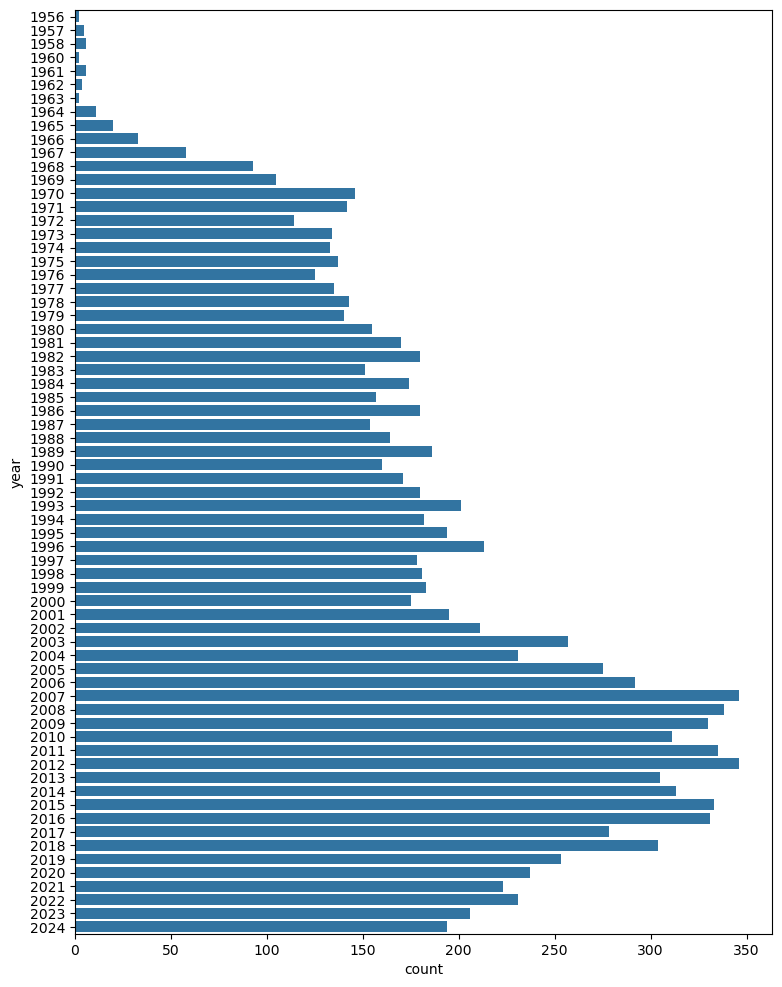

In [125]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')

In [ ]:
df.shape

In [ ]:
df.drop(columns=['album_id', 'rating', 'votes'], inplace=True)
df.shape

(9927, 13)

In [196]:
df.to_csv('Datasets/df_masters_ratings_uk.csv', index=False)

## Statistics

In [418]:
# average number of votes
np.mean(df['votes'])

KeyError: 'votes'

In [417]:
plt.figure(figsize=(15,5))
sns.histplot(data=df[df['votes']>100], x='rating')

KeyError: 'votes'

<Figure size 1500x500 with 0 Axes>

<Axes: xlabel='votes', ylabel='Count'>

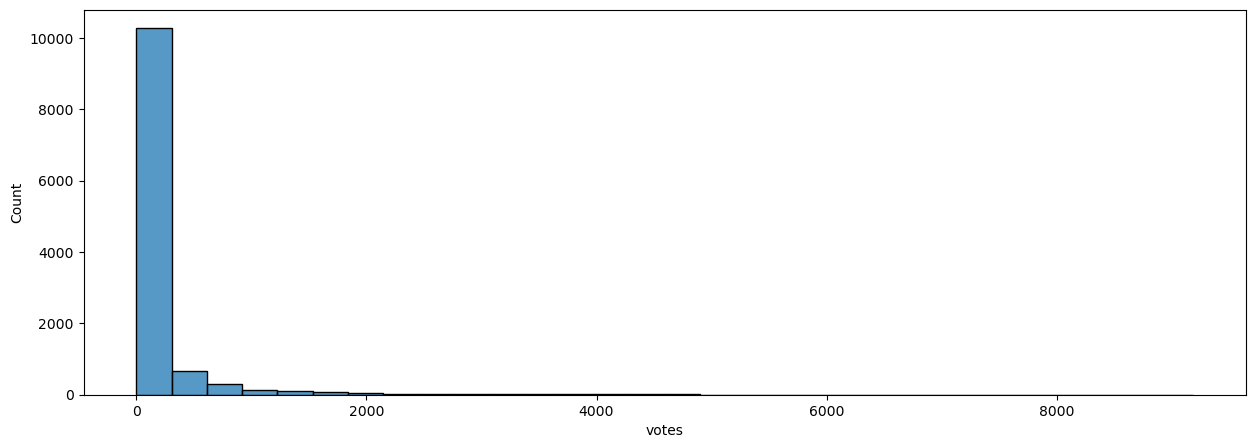

In [35]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_masters_ratings[df_masters_ratings['votes']>1], x='votes', bins=30)

<Axes: xlabel='count', ylabel='year'>

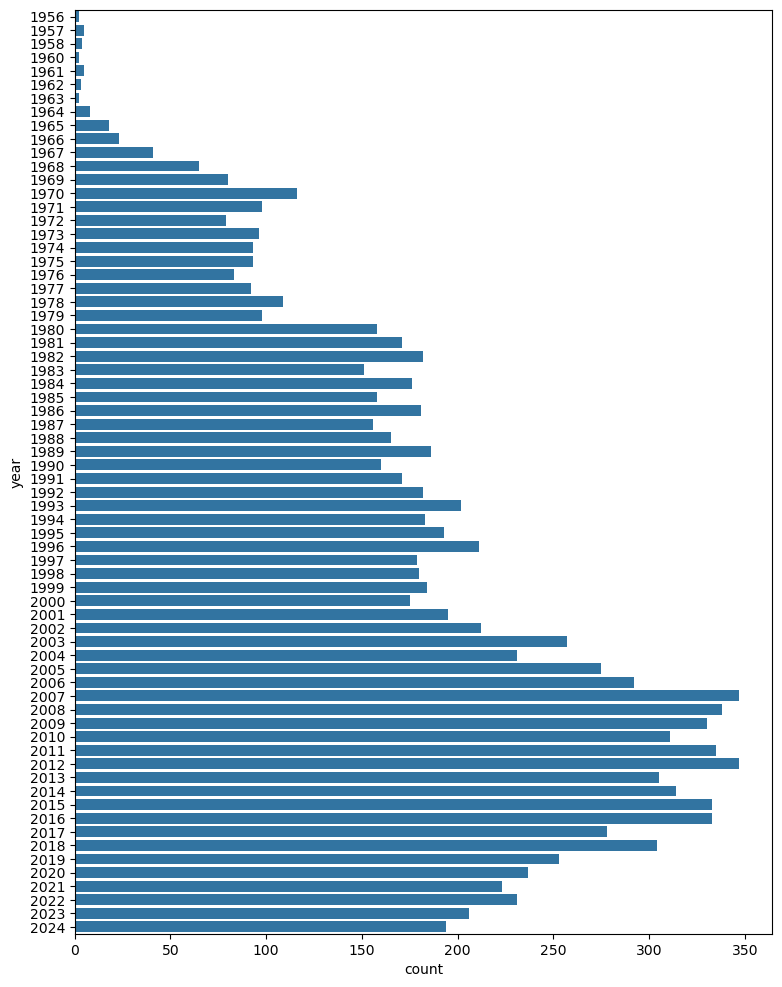

In [54]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')

# Merge with prog albums

In [ ]:
df_masters[df_masters['styles'].str.contains('Prog Rock')].shape

(3763, 13)

In [65]:
df_prog_artists = pd.read_csv('Datasets/df_prog_artists.csv')
df_prog_artists.shape

(12589, 4)

Since by default ``pd.merge`` is case-sensitive, I will create a temporary column with ``assign`` to merge the dataframes and then drop this temporary column and the one from ``df_prog_artists``, which I don't like because it's in uppercase

In [32]:
df_prog_ratings = pd.merge(
    df_ratings.assign(artist_lower=df_ratings['artist'].str.lower()), 
    df_prog_artists.assign(artist_lower=df_prog_artists['artist'].str.lower()), 
    on='artist_lower'
).drop(columns=['artist_lower', 'artist_y', 'href'])
# drop columns I don't need anymore

# rename columns
df_prog_ratings.rename(columns={'artist_x': 'artist'}, inplace=True)

# show the df
df_prog_ratings

,album_id,artist,title,rating,votes,style,country
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom
2,45,Finch,What It Is to Burn,3.69,864,Symphonic Prog,Netherlands
3,53,Dream Theater,Train of Thought,3.87,2670,Progressive Metal,United States
4,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom
...,...,...,...,...,...,...,...
22142,516781,Buckethead,Castello Dwellers,4.50,1,Prog Related,United States
22143,516782,Buckethead,Signaling Across Time,4.00,1,Prog Related,United States
22144,516783,Buckethead,The Mines of Sigismund Fugger,4.00,1,Prog Related,United States
22145,516817,Jack O' The Clock,Portraits,4.00,1,Prog Folk,United States


In [66]:
df_prog_ratings[df_prog_ratings['votes']>10]

,album_id,artist,title,rating,votes,style,country
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom
2,45,Finch,What It Is to Burn,3.69,864,Symphonic Prog,Netherlands
3,53,Dream Theater,Train of Thought,3.87,2670,Progressive Metal,United States
4,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom
...,...,...,...,...,...,...,...
22026,509781,Vylet Pony,Monarch of Monsters,3.77,13,Eclectic Prog,United States
22043,510543,Eidola,Mend,2.63,41,Experimental/Post Metal,United States
22046,510919,Ulver,Liminal Animals,3.26,73,Post Rock/Math rock,Norway
22137,516387,Obscura,A Sonication,2.75,48,Rock Progressivo Italiano,Italy


In [36]:
df_prog = pd.merge(df_prog_ratings, df_masters, on=['artist', 'title'])
df_prog

,album_id,artist,title,rating,votes,style,country,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom,1003,11052,7781939,Europe,2003,52.18,14,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],"Muse are an English rock band from Teignmouth,..."
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom,1003,11001,446060,UK,1999,49.65,12,"['Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Prog Rock']","Muse are an English rock band from Teignmouth,..."
2,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom,144998,302,696772,UK,1970,0.00,8,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Heavy Metal']",Considered by many to be the first heavy metal...
3,70,Yes,Relayer,4.19,1114,Symphonic Prog,United Kingdom,50263,35126,4506926,UK,1974,40.47,3,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...
4,77,Iron Maiden,Dance Of Death,3.59,2074,Prog Related,United Kingdom,251595,21512,8663555,Europe,2003,67.95,11,['Album'],['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,502885,Hats Off Gentlemen It's Adequate,Nostalgia For Infinity,3.50,1,Crossover Prog,United Kingdom,6476937,2726864,15871538,UK,2020,47.98,8,"['Album', 'Stereo']",['Rock'],['Prog Rock'],NaN
1574,502886,Hats Off Gentlemen It's Adequate,The Confidence Trick,4.00,1,Crossover Prog,United Kingdom,6476937,2726867,23954783,UK,2022,68.12,13,"['Album', 'Stereo']",['Rock'],['Prog Rock'],NaN
1575,505233,Efterklang,Things We Have In Common,3.50,2,Post Rock/Math rock,Denmark,234846,3612478,31842014,"UK, Europe & US",2024,0.00,9,"['LP', 'Album']","['Electronic', 'Rock', 'Pop']","['Abstract', 'Indie Rock', 'Folk Rock']",Experimental indie/post-rock/orchestral band f...
1576,505271,Delta Sleep,Blue Garden,3.24,23,Crossover Prog,United Kingdom,3352599,3633390,32079486,US,2024,42.80,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Math Rock', 'Indie Rock']","Formed in 2008 as 'Sávlön' in Canterbury, UK, ..."


In [37]:
df_prog[df_prog['votes']>10]

,album_id,artist,title,rating,votes,style,country,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom,1003,11052,7781939,Europe,2003,52.18,14,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],"Muse are an English rock band from Teignmouth,..."
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom,1003,11001,446060,UK,1999,49.65,12,"['Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Prog Rock']","Muse are an English rock band from Teignmouth,..."
2,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom,144998,302,696772,UK,1970,0.00,8,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Heavy Metal']",Considered by many to be the first heavy metal...
3,70,Yes,Relayer,4.19,1114,Symphonic Prog,United Kingdom,50263,35126,4506926,UK,1974,40.47,3,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...
4,77,Iron Maiden,Dance Of Death,3.59,2074,Prog Related,United Kingdom,251595,21512,8663555,Europe,2003,67.95,11,['Album'],['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,484810,Plantoid,Terrapath,3.59,19,Eclectic Prog,United Kingdom,13894711,3384352,29671858,UK,2024,39.25,10,"['LP', 'Album', 'Special Edition']","['Jazz', 'Rock']","['Prog Rock', 'Psychedelic Rock']",The band began as the brainchild of Chloe Spen...
1563,486448,Ihsahn,Ihsahn,3.81,193,Tech/Extreme Prog Metal,Norway,122289,3395569,29815420,NaN,2024,0.00,11,"['WAV', 'Album', 'Stereo']",['Rock'],"['Progressive Metal', 'Avantgarde']","Composer, singer and multi-instrumentalist fro..."
1566,490484,Dirty Three,Love Changes Everything,3.32,18,Post Rock/Math rock,Australia,65791,3517705,30983092,Australia & New Zealand,2024,41.33,6,"['LP', 'Album', 'Stereo']",['Rock'],['Post Rock'],Australian instrumental rock band founded duri...
1571,495923,Kingcrow,Hopium,3.49,20,Progressive Metal,Italy,1986621,3588815,31565200,"UK, Europe & US",2024,53.33,10,['Album'],['Rock'],"['Progressive Metal', 'Prog Rock']",Kingcrow are an Italian band born in Anguillar...


In [38]:
df_prog[df_prog['votes']>10].artist.nunique()

351

# Concat with the previous ``df_master_id_0``

In [7]:
df_masters_id0_2003 = pd.read_csv('Datasets/df_masters_id0_2003.csv')
df_masters_id0_2003.shape

(850, 13)

In [15]:
df_masters_id0_2003.year.value_counts()

year
2003    850
Name: count, dtype: int64

In [4]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(844, 13)

In [5]:
df_masters_id0.year.value_counts()

year
2004    791
2024     21
2002     12
2000      9
2003      7
2001      4
Name: count, dtype: int64

In [18]:
df_masters_id0_concat = pd.concat([df_masters_id0_2001, df_masters_id0_2002, df_masters_id0_2003])
df_masters_id0_concat.shape

(2329, 13)

In [19]:
df_masters_id0_concat.year.value_counts()

year
2003    850
2002    778
2001    701
Name: count, dtype: int64

# ``df_id0_ratings`` cleaning

## Dropping duplicated albums

In [29]:
# check if there are duplicates
df_id0_ratings.duplicated().sum()

2

In [30]:
# drop duplicates
df_id0_ratings.drop_duplicates(subset=['artist', 'title'], inplace=True)
df_id0_ratings.shape[0]

26

**Dropping live albums, compilations...**

In [31]:
# drop compilations
df_id0_ratings = df_id0_ratings[~df_id0_ratings['release_type'].str.contains('Compilation')]
df_id0_ratings.shape[0]

26

In [34]:
df_id0_ratings.sort_values(['votes', 'title', 'artist'], ascending=False)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
10,1758,Counting Crows,Hard Candy,3.35,138,262643.0,NaN,30989143,UK,2002,0.00,15,"['Album', 'Unofficial Release']",['Rock'],"['Southern Rock', 'Alternative Rock']",Counting Crows is an American rock band from B...
44,123688,The Little Explorer,The Little Explorer,3.80,27,1100295.0,NaN,2747168,UK,2003,0.00,8,['Album'],['Rock'],['Emo'],NaN
38,79784,Tygers Of Pan Tang,Mystical,2.30,10,407694.0,NaN,4632749,UK,2001,49.37,11,['Album'],['Rock'],"['Heavy Metal', 'Hard Rock']",British Heavy Metal band from Whitley Bay form...
12,6347,Howards Alias,The Chameleon Script,4.11,9,918301.0,NaN,1393346,UK,2002,37.03,11,['Album'],['Rock'],"['Ska', 'Punk', 'Indie Rock']","Band in the modern UK underground punk scene, ..."
17,17416,The String Cheese Incident,Untying The Not,3.43,7,246185.0,NaN,32414148,UK & Europe,2003,54.35,13,['Album'],"['Jazz', 'Rock', 'Folk, World, & Country']","['Bluegrass', 'Alternative Rock', 'Jazz-Rock',...",The String Cheese Incident (SCI) is an America...
28,34630,Darkflight,Under The Shadow Of Fear,3.17,6,334729.0,NaN,1301861,UK,2003,40.35,8,['Album'],['Rock'],"['Black Metal', 'Doom Metal']","Atmospheric black/doom metal duo from Varna, B..."
34,61038,Sputniks Down,Much Was Decided Before You Were Born,2.08,6,43018.0,NaN,594879,UK,2001,47.18,7,['Album'],"['Electronic', 'Rock']",['Post Rock'],"Sputniks Down were a Scottish band, made up of..."
8,1651,Miocene,Cellular Memory,3.75,6,958779.0,NaN,1809183,UK,2002,40.60,6,['Album'],['Rock'],[],"Forming in 1998, but consolidating their line-..."
52,188309,Karnataka,Delicate Flame Of Desire,3.80,5,1420825.0,NaN,1726424,UK,2003,61.50,9,['Album'],['Rock'],"['Folk Rock', 'Prog Rock']","Progressive Rock band from Swansea, Wales, UK"
35,61942,Fallen To,The Mark,2.67,3,1198317.0,NaN,3005917,UK,2002,43.80,11,['Album'],['Rock'],['Nu Metal'],NaN


In [35]:
# check one by one if necessary
try:
    df_id0_ratings.drop([49, 50, 51], axis=0, inplace=True)
    print('Rows dropped')
    print(df_id0_ratings.shape)
except:
    print("Couldn't drop these rows")
    print(df_id0_ratings.shape)

Rows dropped
(23, 16)


## Concat with the previous ``df_master_id_0``

In [36]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(30, 16)

In [37]:
df_masters_id0_concat = pd.concat([df_masters_id0, df_id0_ratings])
df_masters_id0_concat.shape

(53, 16)

## **Export to csv**

In [49]:
df_masters.to_csv('Datasets/df_masters.csv', index=False)

In [40]:
df_masters_id0_concat.to_csv('Datasets/df_masters_id0.csv', index=False)

In [3]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(30, 16)

In [4]:
df_masters_id0

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,498666,Blasfeme,Black Legion,3.59,33,8287884.0,NaN,32987169,UK,2024,32.33,7,"['Album', 'Limited Edition']",['Rock'],['Black Metal'],"Blasfeme is a two piece black metal force, fue..."
1,507340,Dawnwalker,The Unknowing,3.68,11,7622357.0,NaN,32331393,UK,2024,0.00,9,"['LP', 'Album']",['Rock'],['Prog Rock'],"Post-Metal/Rock band from London, UK."
2,504016,Trash Boat,Heaven Can Wait,2.64,11,3896679.0,NaN,32921493,UK,2024,36.03,11,"['12""', '33 ⅓ RPM', 'Album', 'Stereo']",['Rock'],['Hardcore'],NaN
3,512234,Caelestra,Bastion,3.95,10,8367186.0,NaN,32682639,UK,2024,48.65,6,['Album'],['Rock'],"['Progressive Metal', 'Post-Metal', 'Black Met...","Caelestra. Bristol, UK. The creation of Fever ..."
4,496271,Other Half,Dark Ageism,3.64,5,4456943.0,NaN,31040566,UK,2024,0.00,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Post-Hardcore', 'Punk']",NaN
5,490535,Ildganger,For Hver Tanke Mister Sj​æ​len Atter Farve,3.62,4,12767564.0,NaN,30251867,UK,2024,0.00,5,"['LP', 'Album', 'Limited Edition']",['Rock'],['Black Metal'],"Black Metal project from Aarhus, Denmark."
6,496009,Gnod,Spot Land,3.12,4,1107254.0,NaN,30624286,UK,2024,0.00,5,"['LP', 'Album', 'Limited Edition']","['Electronic', 'Rock']","['Alternative Rock', 'Industrial', 'Drone', 'M...","Gnod are a British rock band from Salford, Gre..."
7,487309,Ilat Mahru,Incipit Akkadian,3.50,3,12679967.0,NaN,30173384,UK,2024,34.33,4,"['Mini-Album', 'Limited Edition']",['Rock'],['Black Metal'],NaN
8,492912,Perseus,Into The Silence,3.50,3,220153.0,NaN,30422189,UK,2024,44.37,11,"['Album', 'Limited Edition']",['Rock'],"['Heavy Metal', 'Power Metal']",Heavy/power metal band from Italy
9,505338,Thank,I Have A Physical Body That Can Be Harmed,3.75,2,6092482.0,NaN,32117175,UK,2024,0.00,10,"['LP', 'Album']","['Hip Hop', 'Rock']","['Noise Rock', 'Post-Punk', 'No Wave']",Noise rock / post-punk / no wave band from Lee...


# ``df_masters`` cleaning

In [16]:
df_masters[df_masters[['artist', 'title']].duplicated()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
87,252121,NaN,11119495,UK,Judas Priest,Screaming For Vengeance,1982,38.28,10,"['LP', 'Album']",['Rock'],['Heavy Metal'],British Heavy Metal band preceding the ‘New Wa...
255,446450,NaN,2035504,UK,The Del-Byzanteens,Lies To Live By,1982,31.15,7,"['LP', 'Album']",['Rock'],"['New Wave', 'Avantgarde']","American group based in New York, featuring fl..."
258,130830,NaN,5604035,UK,Felt,Crumbling The Antiseptic Beauty,1982,0.00,6,"['LP', 'Album']",['Rock'],"['Alternative Rock', 'Ethereal']","English indie pop band from Water Orton, Warwi..."
297,161785,NaN,13695605,UK,Theatre Of Hate,Westworld,1982,0.00,10,"['LP', 'Album']",['Rock'],['Goth Rock'],Theatre of Hate are a British post-punk band w...
304,251595,NaN,17855461,UK,Iron Maiden,The Number Of The Beast,1982,39.18,8,"['LP', 'Album', 'Stereo']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43861,4637602,1510124.0,13288778,Europe,A Mote Of Dust,A Mote Of Dust,2019,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Post Rock', 'Folk Rock']","Solo project of Craig b (Aereogramme, The Unw..."
43887,159169,81033.0,378703,US,Jeff Buckley,Live At Sin-é,2003,160.95,38,[],['Rock'],"['Alternative Rock', 'Folk Rock']","Jeffrey Scott Buckley (November 17, 1966 - May..."
44015,50263,555721.0,10747602,US,Yes,Yessongs,1984,70.00,1,"['Stereo', 'NTSC']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...
44050,218108,16135.0,861751,Europe,Marillion,Brave,1994,71.03,11,['Album'],['Rock'],"['Classic Rock', 'Prog Rock', 'Symphonic Rock']","Marillion formed in Aylesbury, Buckinghamshire..."


In [15]:
df_masters.shape

(45374, 13)

In [47]:
df_masters[df_masters['artist']=="Kingston Wall"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [ ]:
# check one by one if necessary
try:
    df_id0_ratings.drop([49, 50, 51], axis=0, inplace=True)
    print('Rows dropped')
    print(df_id0_ratings.shape)
except:
    print("Couldn't drop these rows")
    print(df_id0_ratings.shape)

In [44]:
artist = "Kingston Wall"

df_ratings[df_ratings['artist']==artist]

,album_id,artist,title,rating,votes
11887,15257,Kingston Wall,Kingston Wall II,4.23,90
15401,19434,Kingston Wall,Kingston Wall I,4.11,51
23213,28724,Kingston Wall,III - Tri-Logy,3.94,45
137350,174775,Kingston Wall,Freakout Remixes,3.00,1
